In [63]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import re
import matplotlib.pyplot as plt 

In [25]:
def convert_to_dataframe(data_loc, save_file=False):
    """
    :param data_loc: string
    :return: (pd dataframe)  returns the data as a dataframe.
    """
    shots = []
    with open(data_loc, 'r') as infile:
        headers = infile.readline()
        for line in infile:
            shot_n = line.strip()
            shot_n = shot_n.split(',')
            shot_n = [re.sub(r'[^a-zA-Z0-9_().-]', '', word) for word in shot_n]
            shots.append(shot_n)
    headers = headers.split(',')
    headers = [re.sub(r'[^a-zA-Z0-9_()-]', '', word) for word in headers]
    new_cols = []
    for i in range(0, len(headers)):
        if headers[i] == 'error':
            continue 
        new_cols.append(headers[i])
        if headers[i] not in no_errors:
            # print(headers[i])
            new_cols.append('error_' + headers[i]) 
    df = pd.DataFrame(shots, columns=new_cols, dtype='float32')
    df = df.drop(3557)
    if save_file:
        df.to_csv(data_loc + '-dataframe')
    return df

In [26]:
df = convert_to_dataframe('/home/adam/data/jet-pedestal-dataset-2021-18-06')


In [28]:
# df.columns.to_list()
main_engineer = ['shot', 'Ip(MA)', 'B(T)', 'R(m)', 'a(m)', 'averagetriangularity', 
                'Meff', 'P_NBI(MW)', 'P_ICRH(MW)', 'P_TOTPNBIPohmPICRH-Pshi(MW)',
                 'plasmavolume(m3)', 'q95', 'gasflowrateofmainspecies1022(es)', 'divertorconfiguration']

FLAGS = ['FLAGDEUTERIUM', 'FLAGHYDROGEN', 'FLAGHDmix', 'FLAGHeJET-C', 
         'FLAGSeeding', 'FLAGKicks', 'FLAGRMP', 'FLAGpellets', 'FLAGHRTSdatavalidated']

seperatrix_profiles = ['neseparatrixfromexpdata1019(m-3)', 'neseparatrixfromfit1019(m-3)']

# Filtering 

#### Main Filtering

- Only Deuterium Shots - 3380/3557
- HRTS Validated (non 0.0 FLAG)- 2471/3557
- Shots with impurities okay
- No RMPS, kicks, or pellets

Total after main filtering: 2031/3557


In [84]:
# df.columns.to_list()
# df[seperatrix_profiles].value_counts()


In [43]:
# print(df[['FLAGDEUTERIUM', 'FLAGHYDROGEN', 'FLAGHDmix', 'FLAGHeJET-C']].value_counts())
print(df[ ['FLAGSeeding', 'FLAGKicks', 'FLAGRMP', 'FLAGpellets']].value_counts())
print('\n')
# print(df[['FLAGHRTSdatavalidated', 'FLAGDEUTERIUM']].value_counts())

FLAGSeeding  FLAGKicks  FLAGRMP  FLAGpellets
0.0          0.0        0.0      0.0            2113
1.0          0.0        0.0      0.0             933
                                 1.0             173
0.0          0.0        0.0      1.0             110
1.0          1.0        0.0      0.0              86
0.0          1.0        0.0      0.0              81
             0.0        1.0      0.0              53
             1.0        0.0      1.0               5
1.0          1.0        0.0      1.0               2
                        1.0      0.0               1
dtype: int64




In [46]:
df_filtered = df[(df['FLAGDEUTERIUM'] == 1.0) & (df['FLAGHRTSdatavalidated'] != 0.0) & (df['FLAGKicks'] == 0.0) & (df['FLAGRMP'] == 0.0)& (df['FLAGpellets'] == 0.0)]

In [56]:
df_filtered_sep = df_filtered[df_filtered['neseparatrixfromexpdata1019(m-3)'] > 0.0]

In [60]:
df_filtered_sep.to_csv('/home/adam/data/seperatrix_dataset.csv')

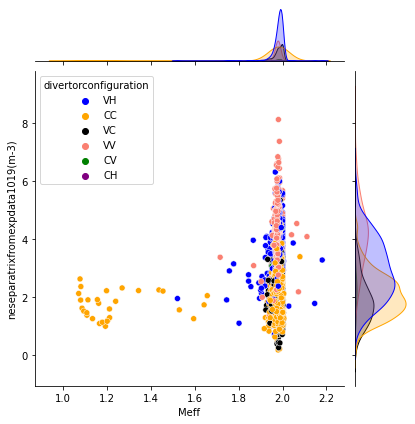

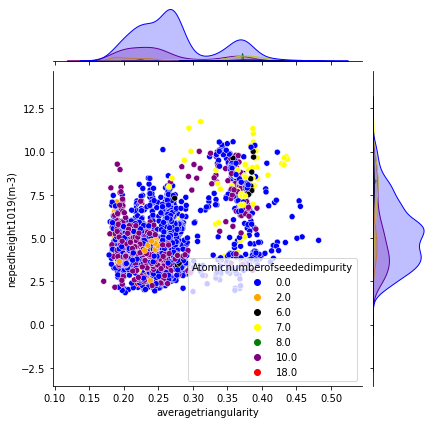

In [175]:
sns.jointplot(y='neseparatrixfromexpdata1019(m-3)', x='Meff', hue='divertorconfiguration', palette=['blue', 'orange', 'black', 'salmon', 'green', 'purple'], data=df_filtered_sep)
sns.jointplot(y='nepedheight1019(m-3)', x='averagetriangularity', hue='Atomicnumberofseededimpurity', palette=['blue', 'orange', 'black', 'yellow', 'green', 'purple', 'red'], data=df_filtered_sep)
plt.show()

In [73]:
df_filtered_sep['Atomicnumberofseededimpurity'].value_counts()

0.0     1258
10.0     358
7.0      107
2.0       51
6.0       21
18.0       4
8.0        3
Name: Atomicnumberofseededimpurity, dtype: int64

In [97]:
df_sep = pd.read_csv('/home/adam/data/seperatrix_dataset.csv')

In [161]:
input_df = df_sep[main_engineer]
target_df = df_sep[seperatrix_profiles]

In [162]:
input_df = input_df.drop(['divertorconfiguration', 'shot'], 1)
target_df = target_df.drop('neseparatrixfromfit1019(m-3)', 1)

In [163]:
X1 = input_df[input_df['averagetriangularity'] >= 0.315]
indices_x1 = X1.index.to_list()
y1 = target_df.iloc[indices_x1]
all_index = [i for i in range(0, len(input_df))]
inidices_x2 = np.setdiff1d(all_index,indices_x1)
X2 = input_df.iloc[inidices_x2]
y2 = target_df.iloc[inidices_x2]

In [170]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [171]:
lin1 = LinearRegression()
lin2= LinearRegression()
x_scale = StandardScaler()
X1 = x_scale.fit_transform(X1)
X2 = x_scale.transform(X2)

In [172]:
lin1.fit(X1, y1)
lin2.fit(X2, y2)

print(lin1.coef_)
print(lin2.coef_)
print(input_df.columns.to_list())
print(np.abs(lin1.coef_ - lin2.coef_))


[[ 1.01042381 -0.44914604  0.29189746  0.48567251 -0.13435568  0.03580659
  -5.56882859 -1.90402028  6.8804144  -0.34916179  0.18197515  0.19598083]]
[[-6.15763103e-01  4.23980227e-01 -6.99772822e-02  4.75178268e-02
   2.12484943e-01  5.89471613e-03 -6.24684034e+00 -2.37492415e+00
   7.76592658e+00 -2.14974764e-02 -5.67878590e-01  3.80594914e-01]]
['Ip(MA)', 'B(T)', 'R(m)', 'a(m)', 'averagetriangularity', 'Meff', 'P_NBI(MW)', 'P_ICRH(MW)', 'P_TOTPNBIPohmPICRH-Pshi(MW)', 'plasmavolume(m3)', 'q95', 'gasflowrateofmainspecies1022(es)']
[[1.62618691 0.87312627 0.36187474 0.43815468 0.34684062 0.02991187
  0.67801175 0.47090387 0.88551218 0.32766432 0.74985374 0.18461409]]


In [173]:
import matplotlib.pyplot as plt 

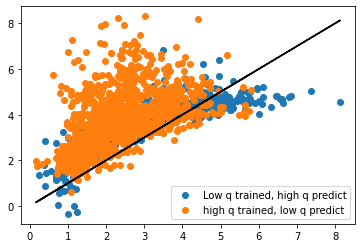

In [174]:
y_preds12 = lin1.predict(X2)
y_preds21 = lin2.predict(X1)

plt.plot(y1, y1, color='black')
plt.plot(y2, y2, color='black')

plt.scatter(y1, y_preds21, label='Low q trained, high q predict')
plt.scatter(y2, y_preds12, label='high q trained, low q predict')
plt.legend()
plt.show()